In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import igraph
from supervenn import supervenn
from covid19.core import model
import tqdm

In [6]:
path_cities = '../data/cities.csv'
path_trf = '../data/raw_data.csv'
path_res = '../data/dummy_sim_res.csv'

In [7]:
data = pd.read_csv(path_trf)

In [8]:
data.head()

,transport,departure,arrival,passengers
0,avia,Москва,Симферополь (Крым),159441
1,avia,Москва,Сочи,149299
2,avia,Симферополь (Крым),Москва,155822
3,avia,Сочи,Москва,143298
4,avia,Санкт-Петербург,Москва,135749


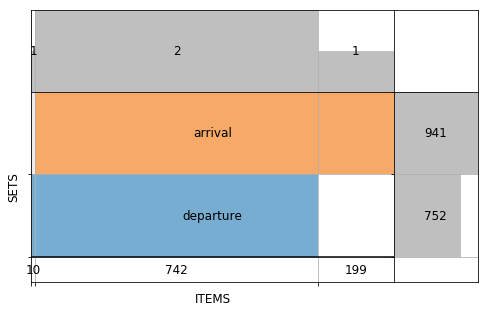

In [9]:
sets = [set(data['departure'].unique()), set(data['arrival'].unique())]
supervenn(sets, set_annotations=['departure', 'arrival'])

In [10]:
data['transport'].unique()

array(['avia', 'bus', 'train'], dtype=object)

In [11]:
all_names = set(data['departure'].unique()).union(data['arrival'].unique())

In [12]:
len(all_names)

951

In [13]:
name2id = {name: i for i, name in enumerate(all_names)}
id2name = {i: name for name, i in name2id.items()}

In [14]:
# For the first run sum all trasport types
grouped_df = data.groupby(['departure', 'arrival'])['passengers'].sum().reset_index()

In [15]:
grouped_df.head()

,departure,arrival,passengers
0,Абакан,Анапа,80
1,Абакан,Анжеро-Судженск,20
2,Абакан,Артышта,14
3,Абакан,Ачинск,374
4,Абакан,Барнаул,1151


In [16]:
grouped_df.shape

(15572, 3)

In [17]:
data.shape

(17388, 4)

# Init graph

In [18]:
edges = [
    (name2id[d], name2id[a]) 
    for d, a in grouped_df[['departure', 'arrival']].values
]

In [19]:
G = igraph.Graph(directed=True)

In [20]:
G.add_vertices(list(range(len(all_names))))

In [21]:
G.add_edges(edges)

In [22]:
G.es['weight'] = (grouped_df['passengers'] / 30).to_list()

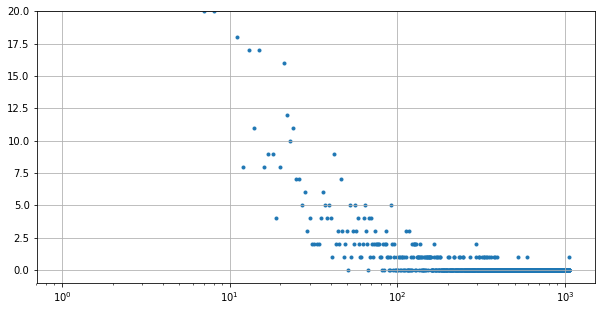

In [23]:
dd = G.degree_distribution()
bins = [b for b in dd.bins()]
plt.figure(figsize=(10, 5))
plt.scatter([l for l, r, b in bins], [b for l, r, b in bins], marker='.');
ax = plt.gca()
ax.set_xscale('log');
ax.grid()
plt.ylim([-1, 20]);

# INIT Cities

### Real data

In [24]:
cities = pd.read_csv(path_cities)
cities.head()

,lat,lng,name,osm_accuracy,population
0,52.651055,90.101159,Абаза,0.593508,17111
1,53.720902,91.442435,Абакан,0.609791,165183
2,53.682800,53.655701,Абдулино,0.587183,20663
3,44.864953,38.157819,Абинск,0.597864,34926
4,56.525460,52.997251,Агрыз,0.596615,19299


# Iters

In [25]:
# TODO: choose realistic numbers
contact_rate, recovery_rate = 10, 10

In [26]:
name2population = {name: population for name, population in cities[['name', 'population']].values}

In [27]:
# TODO: change 1 and 0 to infected and recovered
id2City = {i: model.City(name, name2population[name]+1, 1, 0) for i, name in id2name.items()}

In [28]:
rows = []
NITER = 10 # Days
S = None
I = None
R = None
for day in tqdm.tqdm(range(NITER)):
    for city_id in G.vs:
        # update SIR
        city = id2City[city_id.index]

        sir = model.SIR(city.population, city.infected, city.recovered,
                  contact_rate, recovery_rate)
        S, I, R = sir.run(1)
        city.infected = I[0]
        city.recovered = R[0]

        # save step result for sity
        rows.append((day, city.name, S[0], I[0], R[0]))

        # send
        # for every departure sample number of infected and recovered
    for city_id in G.vs:
        city = id2City[city_id.index]
        for dest_city_id in G.successors(city_id):
            edge_id = G.get_eid(city_id, dest_city_id)

            # TODO: split by individual vehicles
            ntravelers = G.es['weight'][edge_id]

            dest_city = id2City[dest_city_id]
            dest_city.population += ntravelers

            inf_t, rec_t = city.send_people(ntravelers)

            # receive
            dest_city.infected += inf_t
            dest_city.recovered += rec_t

100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


In [29]:
rows[-10:]

[(9, 'Галич', 17442.600000000002, 1.0, 0.0),
 (9, 'Вяземский', 14544.400000000003, 0.0, 0.0),
 (9, 'Енисейск', 19204.300000000007, -77.0, 0.0),
 (9, 'Барабинск', 30751.399999999954, 0.0, 0.0),
 (9, 'Липецк', 103920.59999999971, 2.0, 0.0),
 (9, 'Тюкалинск', 13296.799999999996, 1.0, 0.0),
 (9, 'Зарайск', 44245.200000000004, 1.0, 0.0),
 (9, 'Арск', 18119.09999999999, 1.0, 0.0),
 (9, 'Онега', 21671.600000000002, 1.0, 0.0),
 (9, 'Братск', 254089.70000000112, -73.0, 0.0)]

In [32]:
dumpdf = pd.DataFrame(rows, columns=['n_iter', 'name', 'suspected', 'infected', 'recovered'])

In [33]:
dumpdf.head()

,n_iter,name,suspected,infected,recovered
0,0,Рыбное,18378.0,1.0,0.0
1,0,Давлеканово,24040.0,1.0,0.0
2,0,Артышта,263.0,1.0,0.0
3,0,Ельня,10095.0,1.0,0.0
4,0,Чемал,4011.0,1.0,0.0


In [34]:
dumpdf.to_csv(path_res)